In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
# from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.metrics import accuracy_score, f1_score,precision_score,roc_auc_score, confusion_matrix
from sklearn.tree import plot_tree
import pickle
import shap
import seaborn as sns
import copy

In [2]:
# load dataset
df = pd.read_csv("../data/heart.csv")

In [3]:
# explore the dataset
print(df.head())
print(df.info())
for column in df.columns:
    print("Unique values for {}:{}".format(column,df[column].unique()))


   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

In [4]:
# checking to see any null values in the data
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

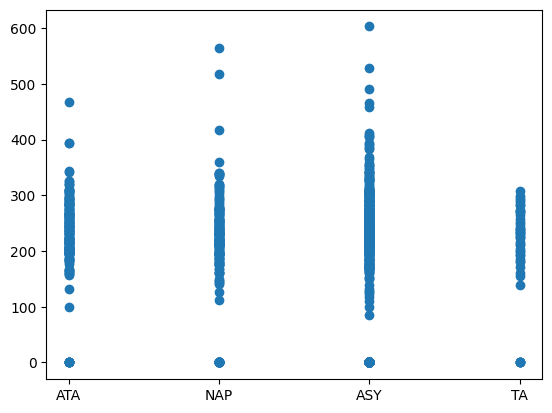

In [5]:
# Some basic plotting to see the data
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(df["Age"],df["Cholesterol"],'o')
ax.plot(df["ChestPainType"],df["Cholesterol"],'o')
# print(df["Cholesterol"].unique())
# print(df["Age"].unique())

In [6]:
numeric_cols_all = ["Age","RestingBP","Cholesterol","FastingBS","MaxHR","Oldpeak"]
categoric_cols_all = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]

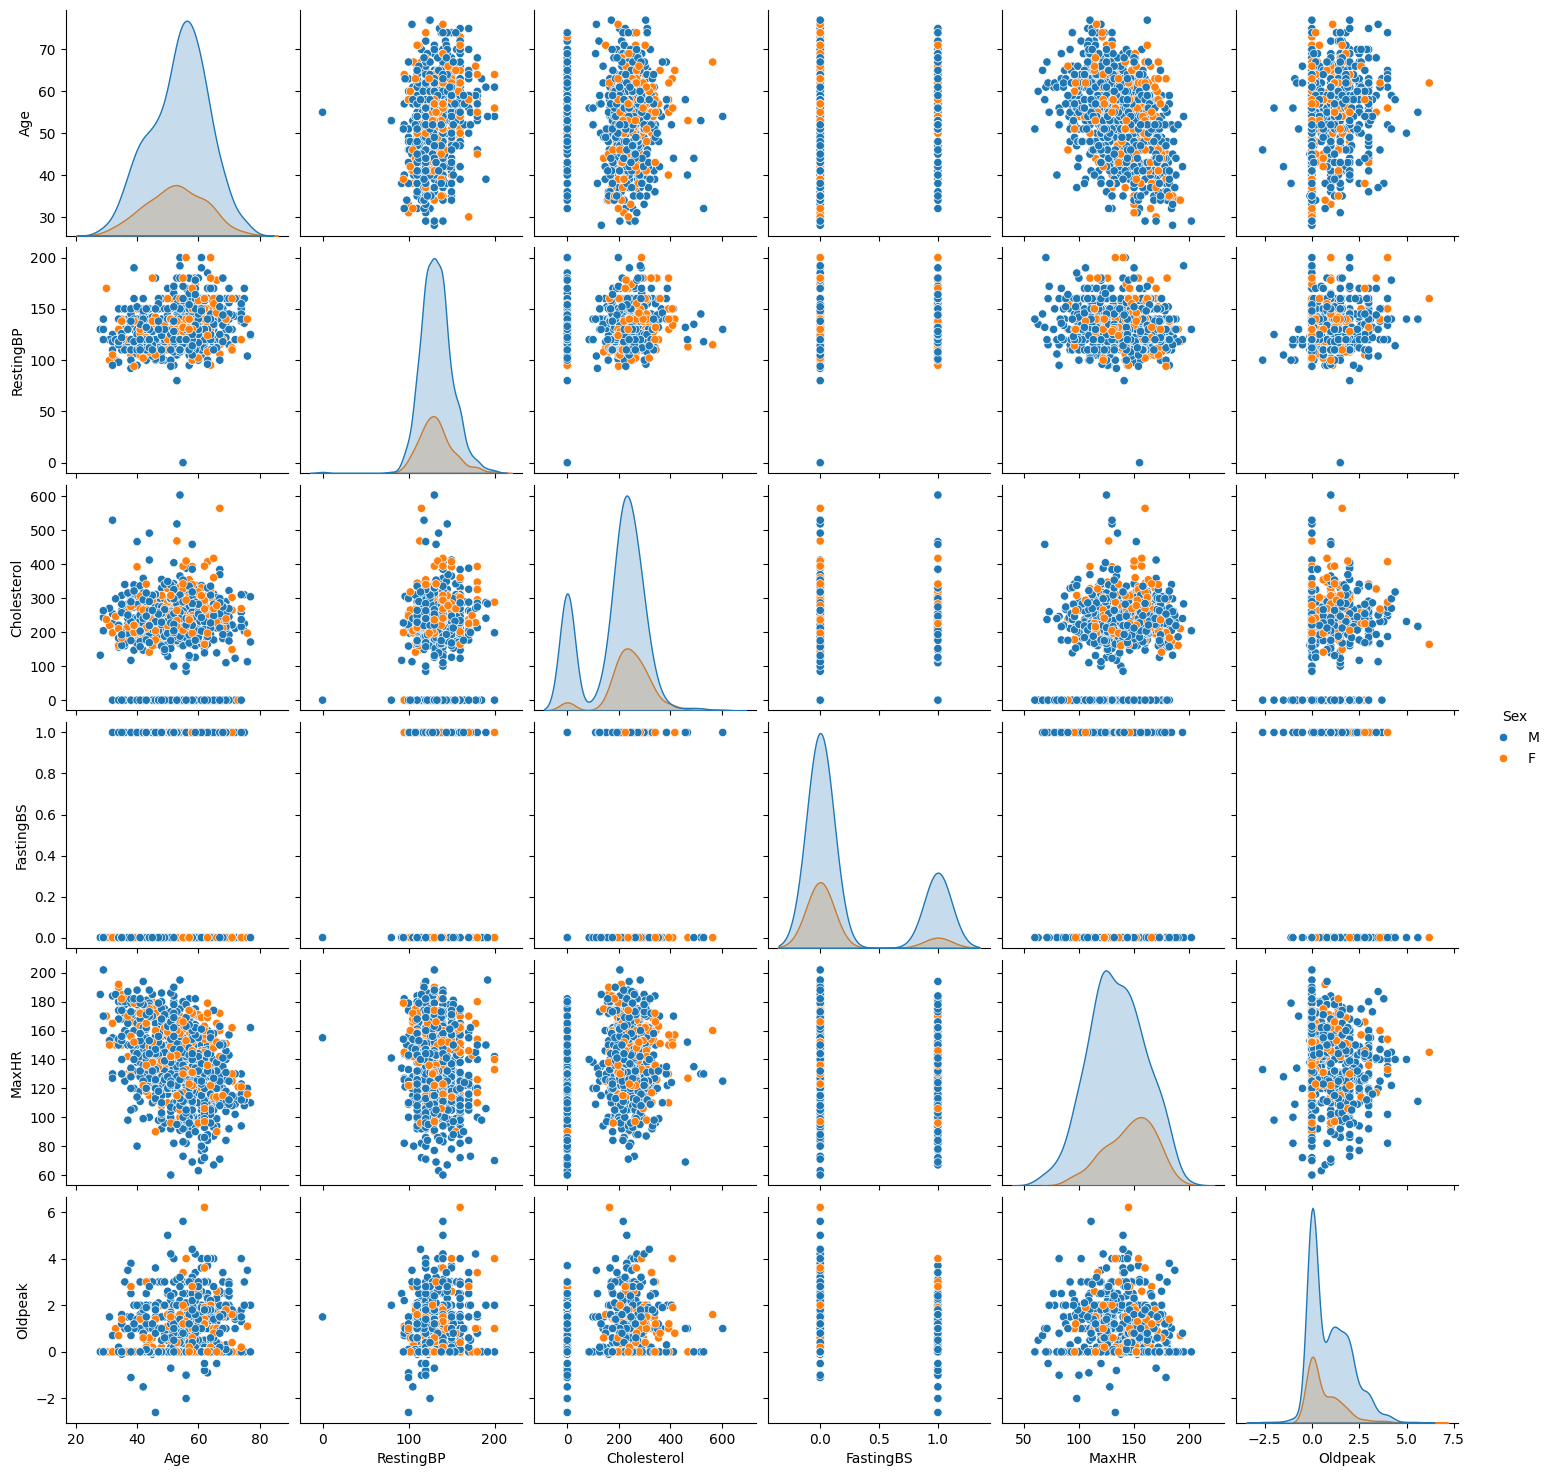

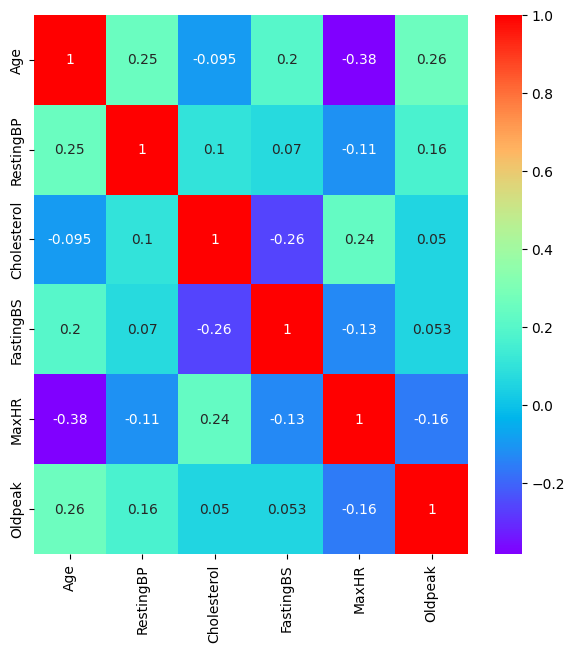

In [11]:
# explore the correlations between the variables in the dataset
sns.pairplot(data=df[numeric_cols_all+["Sex"]],hue="Sex")
plt.savefig("../figures/anup_figures/correlation_structure_seaborn_anup_pillai.png")
plt.figure(figsize = (7,7))
sns.heatmap(df[numeric_cols_all].corr(), annot = True, cmap="rainbow")
plt.savefig("../figures/anup_figures/correlation_heatmap_seaborn_anup_pillai.png")
plt.show()

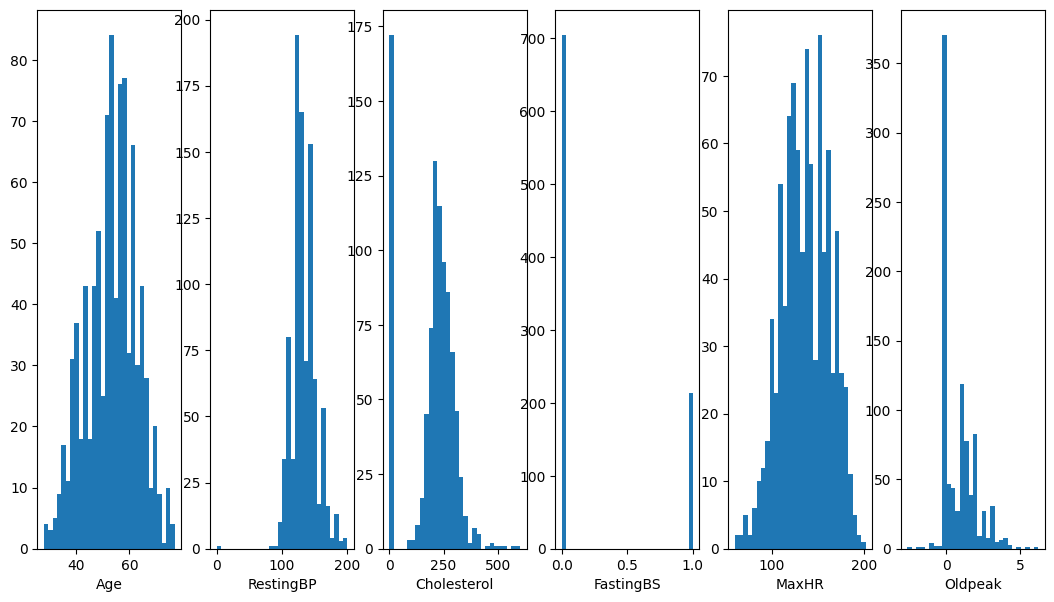

In [12]:
# test predictor variables distributions
plt.close('All')
fh, axs = plt.subplots(nrows=1,ncols=len(numeric_cols_all),figsize=(13, 7))
for i in np.arange(len(numeric_cols_all)):
    axs[i].hist(df[numeric_cols_all[i]],bins=30)
    axs[i].set_xlabel(numeric_cols_all[i])

In [13]:
# Preprocessing pipeline 
# Define column transformers for each column type
num_cols = numeric_cols_all
cat_cols = categoric_cols_all
preproc = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), cat_cols)
    ],remainder='drop'
)
preproc

ColumnTransformer(transformers=[('num_scaler', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol',
                                  'FastingBS', 'MaxHR', 'Oldpeak']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope'])])

In [14]:
# create a baseline model
dtreeCLF = DecisionTreeClassifier(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('dtreeCLF', dtreeCLF)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('dtreeCLF', DecisionTreeClassifier(random_state=42))])

In [15]:
# Create the features data frame and target data.
X = df.drop(columns = 'HeartDisease')
y = df['HeartDisease']

In [16]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 80% training and 20% test

In [17]:
# setup scoring
scoring = {
    'accuracy':make_scorer(accuracy_score)
    # 'prec':'precision'
    # 'f1':'f1_score',
    # 'roc-auc':'roc_auc_score'
}
print(scoring)

{'accuracy': make_scorer(accuracy_score, response_method='predict')}


In [18]:
# Hyperparameter tuning for pipeline

param_grid = {
    'dtreeCLF__max_depth': [3,5,7,10,20],
    'dtreeCLF__min_samples_split':[10,20,30],
    'dtreeCLF__min_samples_leaf':[5,10,20,30,50,100],
    'dtreeCLF__criterion':["gini","entropy"]
}


In [19]:
# Perform cross-validation using grid-search

grid_search = GridSearchCV(
    pipeline, # Pipeline
    param_grid=param_grid,
    scoring='accuracy',
    verbose = 1,
    cv=5,
    return_train_score=True,
)

In [20]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
CPU times: user 12.8 s, sys: 1.64 ms, total: 12.8 s
Wall time: 12.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope'])])),
                                       ('dtreeCLF',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dtreeCLF__criterion': ['gini', 'entropy'],
                         'dtreeCLF__max_depth': [3, 5, 7, 10, 20],
                         'dtreeCLF__min_samples_leaf': [5, 10, 20, 30, 50, 100],
                         'dtreeCLF__min_samples_split': [10, 20, 30]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [22]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head(n=5)
# score_df.columns

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtreeCLF__criterion,param_dtreeCLF__max_depth,param_dtreeCLF__min_samples_leaf,param_dtreeCLF__min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007124,0.001828,0.003603,0.000287,gini,3,5,10,"{'dtreeCLF__criterion': 'gini', 'dtreeCLF__max...",0.875969,...,0.839462,0.028664,1,0.846004,0.847953,0.848249,0.852140,0.861868,0.851243,0.005673
1,0.006198,0.000395,0.003603,0.000133,gini,3,5,20,"{'dtreeCLF__criterion': 'gini', 'dtreeCLF__max...",0.875969,...,0.839462,0.028664,1,0.846004,0.847953,0.848249,0.852140,0.861868,0.851243,0.005673
2,0.006183,0.000293,0.003587,0.000189,gini,3,5,30,"{'dtreeCLF__criterion': 'gini', 'dtreeCLF__max...",0.852713,...,0.825436,0.029984,11,0.846004,0.847953,0.846304,0.852140,0.850195,0.848519,0.002344
3,0.006020,0.000140,0.003415,0.000034,gini,3,10,10,"{'dtreeCLF__criterion': 'gini', 'dtreeCLF__max...",0.852713,...,0.831686,0.024507,7,0.846004,0.847953,0.846304,0.856031,0.859922,0.851243,0.005673
4,0.005879,0.000032,0.003404,0.000032,gini,3,10,20,"{'dtreeCLF__criterion': 'gini', 'dtreeCLF__max...",0.852713,...,0.831686,0.024507,7,0.846004,0.847953,0.846304,0.856031,0.859922,0.851243,0.005673


In [23]:
print(grid_search.best_estimator_.get_params)
grid_search.best_estimator_

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('dtreeCLF',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=5,
                                 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('dtreeCLF',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=5,
                                        min_samples_split=10,
                                        random_state=42))])

In [24]:
def evaluate_model(dtreeCLF):
    print("Train Accuracy :", accuracy_score(y_train, dtreeCLF.predict(X_train)))
    print("Train Precision :", precision_score(y_train, dtreeCLF.predict(X_train)))
    print("Train F1-score :", f1_score(y_train, dtreeCLF.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dtreeCLF.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dtreeCLF.predict(X_test)))
    print("Test Precision :", precision_score(y_test, dtreeCLF.predict(X_test)))
    print("Test F1-score :", f1_score(y_test, dtreeCLF.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dtreeCLF.predict(X_test)))

In [26]:
dtreeCLF_best_all_predictors = grid_search.best_estimator_
evaluate_model(dtreeCLF_best_all_predictors)

Train Accuracy : 0.8520249221183801
Train Precision : 0.8487394957983193
Train F1-score : 0.8644793152639088
Train Confusion Matrix:
[[244  54]
 [ 41 303]]
--------------------------------------------------
Test Accuracy : 0.8369565217391305
Test Precision : 0.8940397350993378
Test F1-score : 0.8571428571428571
Test Confusion Matrix:
[[ 96  16]
 [ 29 135]]


['num_scaler__Age' 'num_scaler__RestingBP' 'num_scaler__Cholesterol'
 'num_scaler__FastingBS' 'num_scaler__MaxHR' 'num_scaler__Oldpeak'
 'onehot__Sex_F' 'onehot__Sex_M' 'onehot__ChestPainType_ASY'
 'onehot__ChestPainType_ATA' 'onehot__ChestPainType_NAP'
 'onehot__ChestPainType_TA' 'onehot__RestingECG_LVH'
 'onehot__RestingECG_Normal' 'onehot__RestingECG_ST'
 'onehot__ExerciseAngina_N' 'onehot__ExerciseAngina_Y'
 'onehot__ST_Slope_Down' 'onehot__ST_Slope_Flat' 'onehot__ST_Slope_Up']


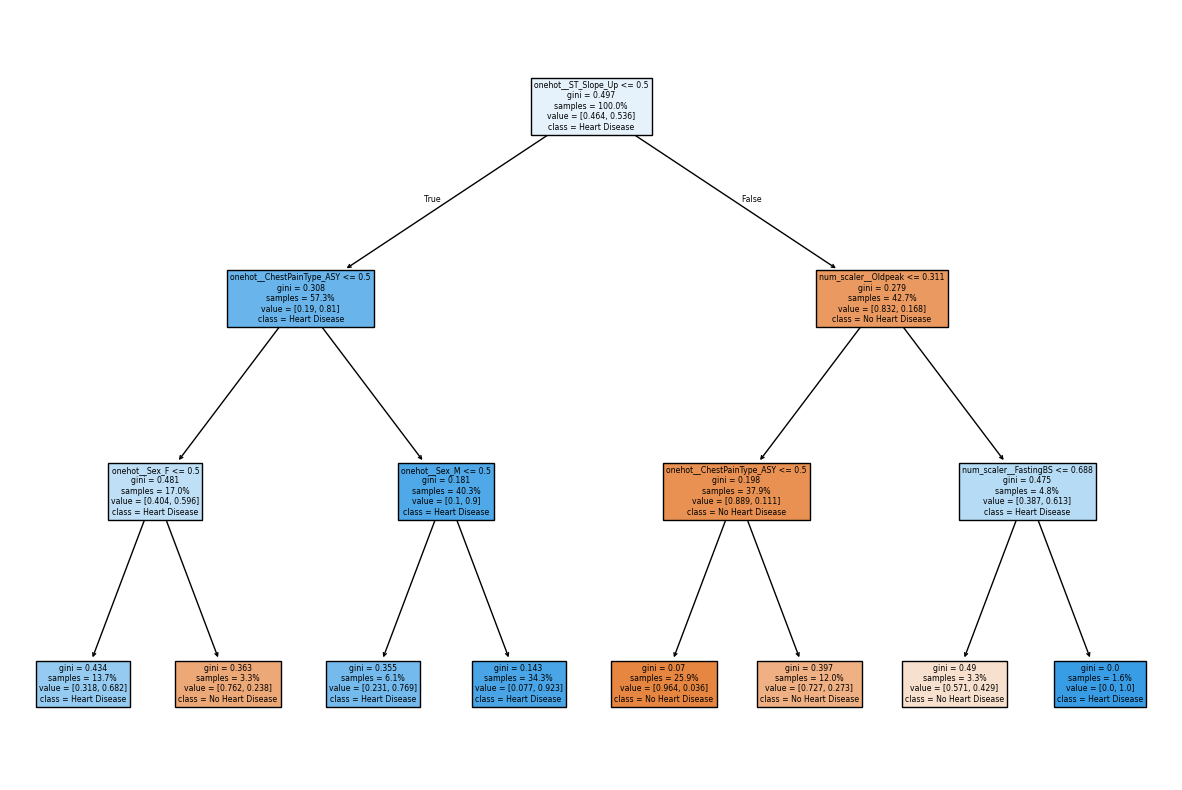

In [28]:
# Plot the tree to visualize
transformed_data = pipeline["preprocessor"].fit_transform(df)
feature_names = pipeline["preprocessor"].get_feature_names_out()
print(feature_names)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
plot_tree(dtreeCLF_best_all_predictors['dtreeCLF'],
          feature_names = feature_names,
          class_names = ["No Heart Disease","Heart Disease"],
          filled =True,
          proportion= True,
          ax=ax
         )
fig.savefig("../figures/anup_figures/visualize_decision_tree_classifier_anup_pillai.png")

In [29]:
predicted_var = dtreeCLF_best_all_predictors.predict(df.drop(columns = 'HeartDisease'))
print(predicted_var)

[0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0
 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0
 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 

Text(0, 0.5, 'Predicted')

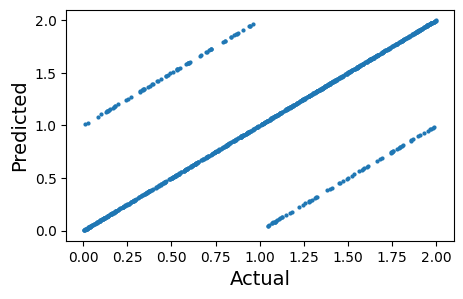

In [30]:
# visualize the predictions
fh = plt.figure(figsize=(5,3))
ax = fh.add_subplot()
np.random.seed(42)
noise = np.random.rand(len(df))
actual = df["HeartDisease"].to_numpy() + noise
ax.plot(actual,predicted_var+noise,'o',markersize=2)
ax.set_xlabel("Actual",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [32]:
# try predictions from an indiviual sample
sample = df.sample(1)
print(sample)
dtreeCLF_best_all_predictors.predict(sample.drop(columns=["HeartDisease"]))

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
186   58   M           ATA        130          251          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
186    110              N      0.0       Up             0  


array([0])

In [33]:
# find out which are the most significant predctors for the model
# strategy: iteratively dropout one variable from the predcitors and see how accuracy is effected
def run_grid_search(X,y,pipeline,param_grid):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 80% training and 20% test
    num_cols = [col for col in X.columns.to_list() if col in numeric_cols_all]
    cat_cols = [col for col in X.columns.to_list() if col in categoric_cols_all]
    print(num_cols)
    print(cat_cols)
    preproc = ColumnTransformer(
        transformers=[
        ('num_scaler', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), cat_cols)
    ],remainder='drop')
    dtreeCLF = DecisionTreeClassifier(random_state=42)
    pipeline = Pipeline(steps=[
        ('preprocessor', preproc),
        ('dtreeCLF', dtreeCLF)])
    # input("key")
    grid_search = GridSearchCV(
        pipeline, # Pipeline
        param_grid=param_grid,
        scoring='accuracy',
        verbose = 1,
        cv=5,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    dtreeCLF_best = grid_search.best_estimator_
    accuracy = accuracy_score(y_test, dtreeCLF_best.predict(X_test))
    return(accuracy)

In [54]:
accuracies = {} # a dict containing accuracies with one target_variable removed form the dataset
target_var = "HeartDisease"
print("Traget Variable: {}".format(target_var))
print(df.columns.to_list())
predictor_vars = df.drop(columns = target_var).columns.to_list() + ["All"]
print(predictor_vars)
for predictor_var in predictor_vars:
    print(predictor_var)
    try:
        X = df.drop(columns = [target_var,predictor_var])
    except:
        X = df.drop(columns = [target_var])
    y = df[target_var]
    accuracy = run_grid_search(X,y,pipeline,param_grid)
    print("Accuracy : {}".format(accuracy))
    accuracies.update({predictor_var:accuracy})
print(accuracies)

Traget Variable: HeartDisease
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'All']
Age
['RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Accuracy : 0.8369565217391305
Sex
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Accuracy : 0.822463768115942
ChestPainType
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Accuracy : 0.8405797

In [34]:
# save accuracies dataframe
accuracies_df = pd.DataFrame.from_dict(accuracies,orient="index")
accuracies_df.rename(columns={0:"accuracies"},inplace=True)
print(accuracies_df)
accuracies_df.sort_values(["accuracies"],inplace=True)
# accuracies.shift(3,axis=0)
print(accuracies_df)
# accuracies.insert(-1,"All",all_col)
# accuracies_df.to_csv("../data/predictor_strength_analysis.csv")

NameError: name 'accuracies' is not defined

                accuracies
ST_Slope          0.789855
Sex               0.822464
FastingBS         0.826087
Age               0.836957
RestingBP         0.836957
Cholesterol       0.836957
RestingECG        0.836957
MaxHR             0.836957
ExerciseAngina    0.836957
All               0.836957
ChestPainType     0.840580
Oldpeak           0.855072


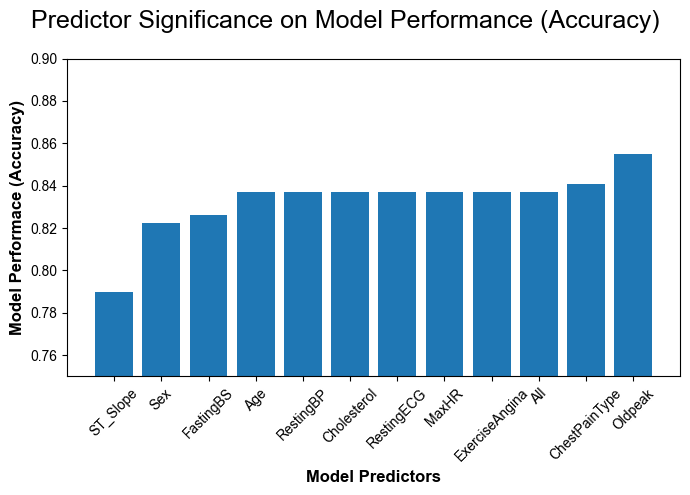

In [43]:
accuracies_df = pd.read_csv("../data/predictor_strength_analysis.csv",index_col=0)
print(accuracies_df)
fh = plt.figure(figsize=(7,5))
ax = fh.add_subplot()
ax.bar(accuracies_df.index.to_list(),accuracies_df["accuracies"])
ax.set_ylim([0.75,0.9])
plt.xticks(rotation=45,fontsize=12,font='Arial')
plt.yticks(rotation=0,fontsize=12,font='Arial')
ax.set_xlabel("Model Predictors",fontsize=12,font='Arial',fontweight='bold')
ax.set_ylabel("Model Performace (Accuracy)",fontsize=12,font='Arial',fontweight='bold')
fh.suptitle("Predictor Significance on Model Performance (Accuracy)",fontsize=18,font="Arial")
plt.tight_layout()
fh.savefig("../figures/anup_figures/strength_of_predctors_decision_tree_anup_pillai.png")
plt.show()

In [58]:
accuracies_df_just_all = accuracies_df.loc[["All"]]
print(accuracies_df)
accuracies_df_dropped = accuracies_df.drop(index=accuracies_df_just_all.index)
print(accuracies_df_dropped)
accuracies_df_reorderd = pd.concat([accuracies_df_dropped,accuracies_df_just_all])
print(accuracies_df_reorderd)

                accuracies
ST_Slope          0.789855
Sex               0.822464
FastingBS         0.826087
Age               0.836957
RestingBP         0.836957
Cholesterol       0.836957
RestingECG        0.836957
MaxHR             0.836957
ExerciseAngina    0.836957
All               0.836957
ChestPainType     0.840580
Oldpeak           0.855072
                accuracies
ST_Slope          0.789855
Sex               0.822464
FastingBS         0.826087
Age               0.836957
RestingBP         0.836957
Cholesterol       0.836957
RestingECG        0.836957
MaxHR             0.836957
ExerciseAngina    0.836957
ChestPainType     0.840580
Oldpeak           0.855072
                accuracies
ST_Slope          0.789855
Sex               0.822464
FastingBS         0.826087
Age               0.836957
RestingBP         0.836957
Cholesterol       0.836957
RestingECG        0.836957
MaxHR             0.836957
ExerciseAngina    0.836957
ChestPainType     0.840580
Oldpeak           0.855072
A

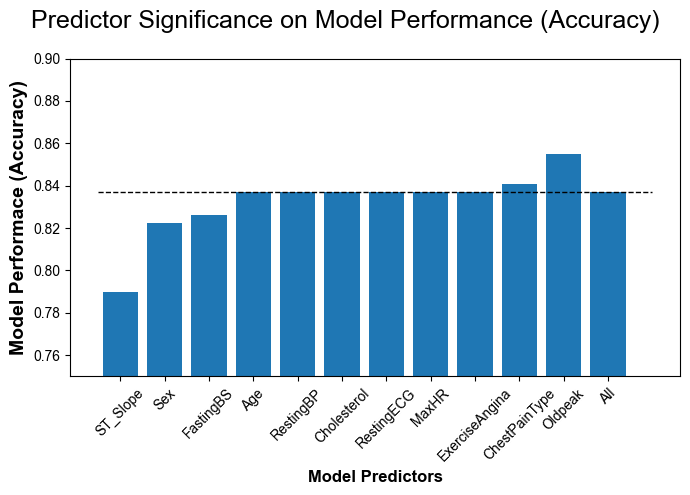

In [80]:
fh = plt.figure(figsize=(7,5))
ax = fh.add_subplot()
ax.bar(accuracies_df_reorderd.index.to_list(),accuracies_df_reorderd["accuracies"])
ax.set_ylim([0.75,0.9])
plt.xticks(rotation=45,fontsize=12,font='Arial')
plt.yticks(rotation=0,fontsize=12,font='Arial')
ax.set_xlabel("Model Predictors",fontsize=12,font='Arial',fontweight='bold')
ax.set_ylabel("Model Performace (Accuracy)",fontsize=14,font='Arial',fontweight='bold')
fh.suptitle("Predictor Significance on Model Performance (Accuracy)",fontsize=18,font="Arial")
ax.hlines(accuracies_df_just_all["accuracies"].to_numpy(),-0.5,12,color='black',linestyle='--',linewidth=1)
plt.tight_layout()
fh.savefig("../figures/anup_figures/strength_of_predctors_decision_tree_anup_pillai.png")
plt.show()